In [48]:
#import geopandas as gpd
import pygeos
import pandas as pd
import json
import numpy as np
import pyproj
from shapely.geometry import shape, MultiPoint
from shapely.prepared import prep

geojson_dict = {
    "type": "Polygon",
    "coordinates": [
        [
            [-3, 0.5],
            [-0.5, 1.5],
            [0.5, 3],
            [3, 3],
            [1, 1.5],
            [1, -0.5],
            [-3, 0.5]
        ]
    ]
}
geojson_string = json.dumps(geojson_dict)
geojson_str2 = '{"type": "Polygon", "coordinates": [[[0, 0], [0, 10], [10, 10], [10, 0], [0, 0]]]}'


# Read GeoJSON from dictionary
poly1 = pygeos.from_shapely(shape(geojson_dict))
#poly1 = pygeos.from_geojson(geojson_string)
poly2 = pygeos.from_geojson(geojson_str2)

# Do something with polygon, e.g. calculate area
print(pygeos.area(poly1) == pygeos.area(poly2))
print(poly1)
print(pygeos.envelope(poly1))
print(pygeos.bounds(poly1))
print(pygeos.boundary(poly1))
#print(pygeos.crs(poly1))

False
POLYGON ((-3 0.5, -0.5 1.5, 0.5 3, 3 3, 1 1.5, 1 -0.5, -3 0.5))
POLYGON ((-3 -0.5, 3 -0.5, 3 3, -3 3, -3 -0.5))
[-3.  -0.5  3.   3. ]
LINESTRING (-3 0.5, -0.5 1.5, 0.5 3, 3 3, 1 1.5, 1 -0.5, -3 0.5)


In [5]:
# Get bounding box of polygon and transform to geographic coordinates
minx, miny, maxx, maxy = pygeos.bounds(poly1)
transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:4326")
minx, miny = transformer.transform(minx, miny)
maxx, maxy = transformer.transform(maxx, maxy)

# Create grid of points within bounding box
n_points = 100
x = np.linspace(minx, maxx, n_points)
y = np.linspace(miny, maxy, n_points)
xx, yy = np.meshgrid(x, y)
points = np.column_stack([xx.ravel(), yy.ravel()])
mpts = MultiPoint(points)
print(mpts)
gpts = pygeos.points(points)
print(gpts)

MULTIPOINT (-3 -0.5, -2.9393939393939394 -0.5, -2.878787878787879 -0.5, -2.8181818181818183 -0.5, -2.757575757575758 -0.5, -2.696969696969697 -0.5, -2.6363636363636362 -0.5, -2.5757575757575757 -0.5, -2.515151515151515 -0.5, -2.4545454545454546 -0.5, -2.393939393939394 -0.5, -2.333333333333333 -0.5, -2.2727272727272725 -0.5, -2.212121212121212 -0.5, -2.1515151515151514 -0.5, -2.090909090909091 -0.5, -2.0303030303030303 -0.5, -1.9696969696969697 -0.5, -1.9090909090909092 -0.5, -1.8484848484848484 -0.5, -1.7878787878787878 -0.5, -1.7272727272727273 -0.5, -1.6666666666666665 -0.5, -1.606060606060606 -0.5, -1.5454545454545454 -0.5, -1.4848484848484849 -0.5, -1.4242424242424243 -0.5, -1.3636363636363635 -0.5, -1.303030303030303 -0.5, -1.2424242424242424 -0.5, -1.1818181818181817 -0.5, -1.121212121212121 -0.5, -1.0606060606060606 -0.5, -1 -0.5, -0.9393939393939394 -0.5, -0.8787878787878789 -0.5, -0.8181818181818183 -0.5, -0.7575757575757573 -0.5, -0.6969696969696968 -0.5, -0.6363636363636362

In [6]:
import polars as pl
# Filter points within polygon using PyGEOS
polyx = shape(json.loads(geojson_string))
poly = pygeos.from_shapely(polyx)
mask = pygeos.within(gpts, poly)
result = points[mask]

# Transform points back to original coordinate system
#result = transformer.transform(result[:, 0], result[:, 1])

#result = []
#prep_polyx = prep(polyx)
#result.extend(filter(prep_polyx.contains, points))

# Convert points to DataFrame with longitude and latitude columns
df = pl.DataFrame({'longitude': result[:, 0],
                   'latitude': result[:, 1]})
print(df)

shape: (3_563, 2)
┌───────────┬───────────┐
│ longitude ┆ latitude  │
│ ---       ┆ ---       │
│ f64       ┆ f64       │
╞═══════════╪═══════════╡
│ 0.878788  ┆ -0.464646 │
│ 0.939394  ┆ -0.464646 │
│ 0.757576  ┆ -0.429293 │
│ 0.818182  ┆ -0.429293 │
│ …         ┆ …         │
│ 2.757576  ┆ 2.964646  │
│ 2.818182  ┆ 2.964646  │
│ 2.878788  ┆ 2.964646  │
│ 2.939394  ┆ 2.964646  │
└───────────┴───────────┘


d:\python\py311\Lib\site-packages\pygeos\io.py:89: UserWarning: The shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the PyGEOS GEOS version (3.10.4-CAPI-1.16.2). Conversions between both will be slow
  warnings.warn(


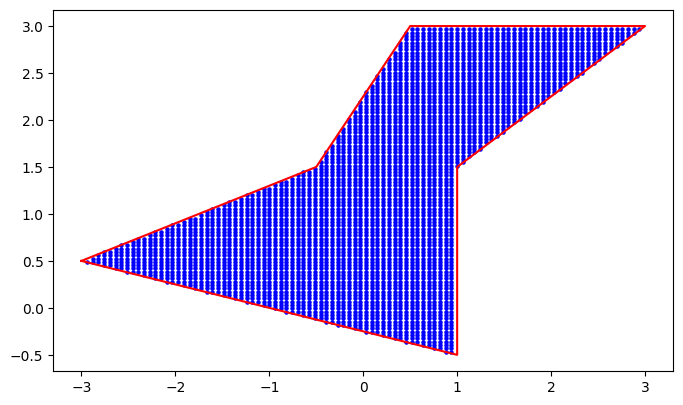

In [5]:
import matplotlib.pyplot as plt
# Plot original envelope of the polygon and points inside the envelope
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax.plot(*polyx.exterior.xy, color="red")
ax.scatter(df["longitude"], df["latitude"], color="blue", s=5)
plt.show()

POLYGON ((-3 0.5, -0.5 1.5, 0.5 3, 3 3, 1 1.5, 1 -0.5, -3 0.5), (-1 1, 1 1, 0 2, -1 1))


AttributeError: 'pygeos.lib.Geometry' object has no attribute 'exterior'

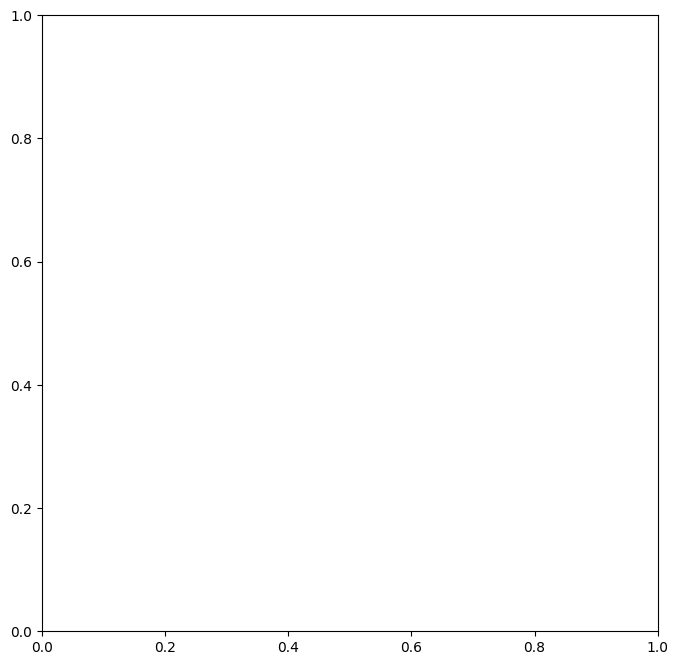

In [51]:
ply_hole_dict = {
    "type": "Polygon",
    "coordinates": [
        [
            [-3, 0.5],
            [-0.5, 1.5],
            [0.5, 3],
            [3, 3],
            [1, 1.5],
            [1, -0.5],
            [-3, 0.5]
        ],
        [
            [-1, 1],
            [1, 1],
            [0, 2],
            [-1, 1]
        ]
    ]
}
polyy = shape(ply_hole_dict)
poly2 = pygeos.from_shapely(polyy)
print(poly2)
#holes = [pygeos.from_shapely(shape(hole)) for hole in ply_hole_dict['coordinates'][1:]]
#hole = pygeos.unary_union(holes)

# Get bounding box of polygon and transform to geographic coordinates
minx, miny, maxx, maxy = pygeos.bounds(poly2)
transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:4326")
minx, miny = transformer.transform(minx, miny)
maxx, maxy = transformer.transform(maxx, maxy)

# Create grid of points within bounding box
n_points = 100
x = np.linspace(minx, maxx, n_points)
y = np.linspace(miny, maxy, n_points)
xx, yy = np.meshgrid(x, y)
point2 = np.column_stack([xx.ravel(), yy.ravel()])

gpt2 = pygeos.points(point2)

# Check if points are within the polygon and not within any holes
mask1 = pygeos.within(gpts, poly2)
#mask2 = pygeos.intersects(gpt2, hole)
#mask = mask1 & ~mask2
result2 = point2[mask1]
df2 = pd.DataFrame({'longitude': result2[:, 0],
                   'latitude': result2[:, 1]})

# import matplotlib.pyplot as plt
# Plot original envelope of the polygon and points inside the envelope
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax.plot(*polyy.exterior.xy, color="red")
ax.scatter(df2["longitude"], df2["latitude"], color="blue", s=5)
plt.show()

In [35]:
#import xarray as xr
import importlib
import simu_gebco01
importlib.reload(simu_gebco01)
from simu_gebco01 import zprofile
#ds1 = xr.open_zarr(
#        'GEBCO_2022_sub_ice_topo.zarr', chunks='auto', group='gebco',
#        decode_cf=False, decode_times=False)

print(zprofile(lon='123,123.15', lat='22.13,22', mode='dataframe'))
print(zprofile(lon='123,123.15', lat='22.13,22', mode='point,dataframe,zonly'))
print(zprofile(lon='123,123.15', lat='22.13', mode='dataframe'))

shape: (38, 4)
┌────────────┬───────────┬───────┬──────────┐
│ longitude  ┆ latitude  ┆ z     ┆ distance │
│ ---        ┆ ---       ┆ ---   ┆ ---      │
│ f64        ┆ f64       ┆ i16   ┆ f64      │
╞════════════╪═══════════╪═══════╪══════════╡
│ 123.0      ┆ 22.13     ┆ -3617 ┆ 0.0      │
│ 123.003125 ┆ 22.127292 ┆ -3722 ┆ 0.440321 │
│ 123.007292 ┆ 22.123681 ┆ -3822 ┆ 0.587102 │
│ 123.011458 ┆ 22.120069 ┆ -3899 ┆ 0.58711  │
│ …          ┆ …         ┆ …     ┆ …        │
│ 123.140625 ┆ 22.008125 ┆ -5613 ┆ 0.587354 │
│ 123.144792 ┆ 22.004514 ┆ -5619 ┆ 0.587362 │
│ 123.148958 ┆ 22.000903 ┆ -5621 ┆ 0.58737  │
│ 123.15     ┆ 22.0      ┆ -5625 ┆ 0.146844 │
└────────────┴───────────┴───────┴──────────┘
shape: (2, 3)
┌───────────┬──────────┬───────┐
│ longitude ┆ latitude ┆ z     │
│ ---       ┆ ---      ┆ ---   │
│ f64       ┆ f64      ┆ i16   │
╞═══════════╪══════════╪═══════╡
│ 123.0     ┆ 22.13    ┆ -3617 │
│ 123.15    ┆ 22.0     ┆ -5625 │
└───────────┴──────────┴───────┘
shape: (0, 3)
┌──

In [15]:

## test line ##
line_dict1 = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            -13.413081630775764,
            -6.920092253225349
          ],
          [
            -7.630064084242605,
            -3.7209743988855024
          ],
          [
            -5.1333868275576435,
            -5.224021020321388
          ]
        ],
        "type": "LineString"
      }
    }
  ]
}

ply1 = pygeos.from_geojson(json.dumps(line_dict1))
print(ply1)
coordx = pygeos.get_coordinates(ply1)
locx = coordx[:,0]
locy = coordx[:,1]
print(locx, locy)
out = zprofile(lon=','.join(str(x) for x in locx),
               lat=','.join(str(y) for y in locy), mode='dataframe')
print(out)


GEOMETRYCOLLECTION (LINESTRING (-13.413 -6.92, -7.63 -3.721, -5.133 -5.224))
[-13.41308163  -7.63006408  -5.13338683] [-6.92009225 -3.7209744  -5.22402102]
Test df1: shape: (1_990, 4)
┌────────────┬───────────┬───────┬──────────┐
│ longitude  ┆ latitude  ┆ z     ┆ distance │
│ ---        ┆ ---       ┆ ---   ┆ ---      │
│ f64        ┆ f64       ┆ i16   ┆ f64      │
╞════════════╪═══════════╪═══════╪══════════╡
│ -13.413082 ┆ -6.920092 ┆ -3227 ┆ 0.0      │
│ -13.409375 ┆ -6.918042 ┆ -3236 ┆ 0.468212 │
│ -13.405208 ┆ -6.915737 ┆ -3250 ┆ 0.526324 │
│ -13.401042 ┆ -6.913432 ┆ -3259 ┆ 0.526326 │
│ …          ┆ …         ┆ …     ┆ …        │
│ -5.142708  ┆ -5.218409 ┆ -4429 ┆ 0.538811 │
│ -5.138542  ┆ -5.220918 ┆ -4391 ┆ 0.538809 │
│ -5.134375  ┆ -5.223426 ┆ -4421 ┆ 0.538808 │
│ -5.133387  ┆ -5.224021 ┆ -4421 ┆ 0.127784 │
└────────────┴───────────┴───────┴──────────┘
shape: (1_990, 4)
┌────────────┬───────────┬───────┬──────────┐
│ longitude  ┆ latitude  ┆ z     ┆ distance │
│ ---        ┆ -

In [16]:
multiline_dict1 =  {
   "type": "MultiLineString",
   "coordinates": [
     [
       [100.0, 0.0],
       [101.0, 1.0]
     ],
     [
       [102.0, 2.0],
       [103.0, 3.0]
     ]
   ]
 }
ply2 = pygeos.from_geojson(json.dumps(multiline_dict1))
print(ply2)
coordx = pygeos.get_coordinates(ply2)
locx = coordx[:,0]
locy = coordx[:,1]
print(locx, locy)

MULTILINESTRING ((100 0, 101 1), (102 2, 103 3))
[100. 101. 102. 103.] [0. 1. 2. 3.]


In [32]:
# Example GeoJSON string with LineString and MultiLineString
geojson_str = '''
{
    "type": "Feature",
    "geometry": {
        "type": "GeometryCollection",
        "geometries": [
            {
                "type": "MultiLineString",
                "coordinates": [
                    [[104, 4], [105, 5], [106, 6]],
                    [[107, 7], [108, 8], [109, 9]]
                ]
            },        
            {
                "type": "LineString",
                "coordinates": [
                    [100, 0], [101, 1], [102, 2], [103, 3]
                ]
            }
        ]
    }
}
'''
#pygeos.get_type_id
#None (missing) is -1
#POINT is 0
#LINESTRING is 1
#LINEARRING is 2
#POLYGON is 3
#MULTIPOINT is 4
#MULTILINESTRING is 5
#MULTIPOLYGON is 6
#GEOMETRYCOLLECTION is 7

# Parse GeoJSON into a dictionary
geojson_dict = json.loads(geojson_str)

# Create empty lists for collecting the output
df_rows = []
line_id = 0

# Iterate over all geometries in the GeometryCollection
for geom in geojson_dict['geometry']['geometries']:
    # Extract the coordinates from the geometry
    coords = geom['coordinates']
    # Convert the coordinates to a PyGEOS geometry object
    geox = pygeos.linestrings(coords) if geom['type'] == 'LineString' else pygeos.multilinestrings(coords)
    print(geox)
    #print(pygeos.get_coordinates(geox))
    typex = pygeos.get_type_id(geox)
    print(typex)

    if typex == 5:  # MultiLineString
        lines = pygeos.get_parts(geox)
        print(lines)
        #lines = lines.tolist()
        #print(lines)
        for i, line in enumerate(lines):
            df_rows.extend([(pt[0], pt[1], i) for pt in pygeos.get_coordinates(line)])
            line_id = line_id + 1
    elif typex == 1:  # LineString:
        df_rows.extend([(pt[0], pt[1], line_id) for pt in pygeos.get_coordinates(geox)])

# Create the DataFrame
df = pl.DataFrame(df_rows, schema={'longitude':pl.Float64, 'latitude':pl.Float64, 'lineid': pl.Int16})
print(df)


MULTILINESTRING ((104 4, 105 5, 106 6), (107 7, 108 8, 109 9))
5
[<pygeos.Geometry LINESTRING (104 4, 105 5, 106 6)>
 <pygeos.Geometry LINESTRING (107 7, 108 8, 109 9)>]
LINESTRING (100 0, 101 1, 102 2, 103 3)
1
shape: (10, 3)
┌───────────┬──────────┬────────┐
│ longitude ┆ latitude ┆ lineid │
│ ---       ┆ ---      ┆ ---    │
│ f64       ┆ f64      ┆ i16    │
╞═══════════╪══════════╪════════╡
│ 104.0     ┆ 4.0      ┆ 0      │
│ 105.0     ┆ 5.0      ┆ 0      │
│ 106.0     ┆ 6.0      ┆ 0      │
│ 107.0     ┆ 7.0      ┆ 1      │
│ …         ┆ …        ┆ …      │
│ 100.0     ┆ 0.0      ┆ 2      │
│ 101.0     ┆ 1.0      ┆ 2      │
│ 102.0     ┆ 2.0      ┆ 2      │
│ 103.0     ┆ 3.0      ┆ 2      │
└───────────┴──────────┴────────┘


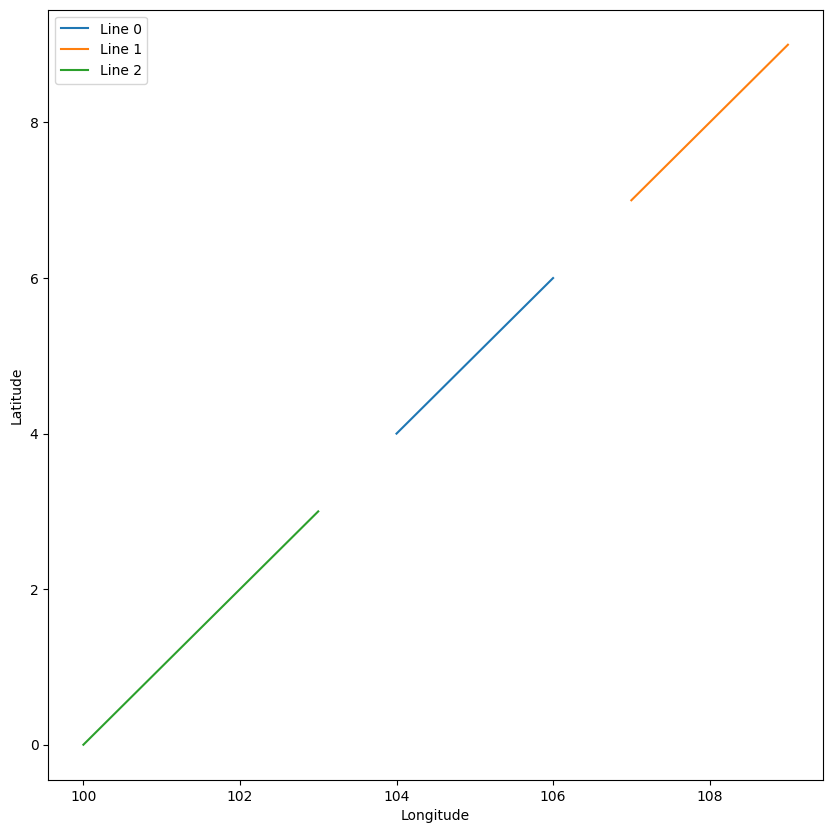

In [33]:
# Plot the lines with different colors according to line ID
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

for line_id in df['lineid'].unique():
    line = df.filter(pl.col('lineid') == line_id)
    ax.plot(line['longitude'], line['latitude'], label=f'Line {line_id}')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.show()

In [46]:
pts_dict = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [-122.4194, 37.7749]
            },
            "properties": {
                "name": "Point 1"
            }
        },
        {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [-122.4382, 37.7592]
            },
            "properties": {
                "name": "Point 2"
            }
        },
        {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [-122.4183, 37.7754]
            },
            "properties": {
                "name": "Point 3"
            }
        },
        {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [-122.4233, 37.7764]
            },
            "properties": {
                "name": "Point 4"
            }
        },
        {
            "type": "Feature",
            "geometry": {
                "type": "MultiPoint",
                "coordinates": [[-122.4194, 37.7749], [-122.4382, 37.7592], [-122.4183, 37.7754], [-122.4233, 37.7764], [-122.4076, 37.7848], [-122.4155, 37.7765], [-122.4115, 37.7858], [-122.4063, 37.7861], [-122.4057, 37.7792], [-122.4232, 37.7799]]
            },
            "properties": {
                "name": "MultiPoint 1"
            }
        },
        {
            "type": "Feature",
            "geometry": {
                "type": "MultiPoint",
                "coordinates": [[-122.4207, 37.7791], [-122.4322, 37.7769], [-122.4177, 37.7733], [-122.4099, 37.7772], [-122.4068, 37.7836], [-122.4197, 37.7838], [-122.4093, 37.7793], [-122.4157, 37.778], [-122.4102, 37.7789], [-122.4147, 37.7772]]
            },
            "properties": {
                "name": "MultiPoint 2"
            }
        }
    ]
}

#ptx = []
ptx = np.empty(shape=[0, 2], dtype=float)

#for geom in pts_dict['features']:
    # Extract the coordinates from the geometry
#    coords = geom['geometry']['coordinates']
    # Convert the coordinates to a PyGEOS geometry object
#    geox = pygeos.points(coords) if geom['geometry']['type'] == 'Point' else pygeos.multipoints(coords)
#    print(geox)
    #print(pygeos.get_coordinates(geox))
    #typex = pygeos.get_type_id(geox)
    #print(typex)
#    ptx.extend(tuple(crdx) for crdx in pygeos.get_coordinates(geox).tolist())
for feature in pts_dict['features']:
    geometry = feature['geometry']
    if geometry['type'] == 'Point':
        coords = np.array(pygeos.get_coordinates(pygeos.points(geometry['coordinates'])))
    elif geometry['type'] == 'MultiPoint':
        coords = np.array(pygeos.get_coordinates(pygeos.multipoints(geometry['coordinates'])))
    else:
        continue  # ignore other types of geometries
    
    ptx = np.vstack([ptx, coords])

print(ptx)
dfpt = pl.DataFrame({'longitude':ptx[:,0], 'latitude':ptx[:,1]})
print(dfpt)

[[-122.4194   37.7749]
 [-122.4382   37.7592]
 [-122.4183   37.7754]
 [-122.4233   37.7764]
 [-122.4194   37.7749]
 [-122.4382   37.7592]
 [-122.4183   37.7754]
 [-122.4233   37.7764]
 [-122.4076   37.7848]
 [-122.4155   37.7765]
 [-122.4115   37.7858]
 [-122.4063   37.7861]
 [-122.4057   37.7792]
 [-122.4232   37.7799]
 [-122.4207   37.7791]
 [-122.4322   37.7769]
 [-122.4177   37.7733]
 [-122.4099   37.7772]
 [-122.4068   37.7836]
 [-122.4197   37.7838]
 [-122.4093   37.7793]
 [-122.4157   37.778 ]
 [-122.4102   37.7789]
 [-122.4147   37.7772]]
shape: (24, 2)
┌───────────┬──────────┐
│ longitude ┆ latitude │
│ ---       ┆ ---      │
│ f64       ┆ f64      │
╞═══════════╪══════════╡
│ -122.4194 ┆ 37.7749  │
│ -122.4382 ┆ 37.7592  │
│ -122.4183 ┆ 37.7754  │
│ -122.4233 ┆ 37.7764  │
│ …         ┆ …        │
│ -122.4093 ┆ 37.7793  │
│ -122.4157 ┆ 37.778   │
│ -122.4102 ┆ 37.7789  │
│ -122.4147 ┆ 37.7772  │
└───────────┴──────────┘


In [ ]:


dis1 = np.array([0])
st = time.time()
for i in range(len(loc1)-1):
  dist = geodesic((loc1[i,1],loc1[i,0]), (loc1[i+1,1],loc1[i+1,0])).km
  dis1 = np.append(dis1, dist, axis=None)
et = time.time()
print('Calculate loop of geo dist time: ', et-st, 'sec')
print(dis1)

In [ ]:
#https://stackoverflow.com/questions/72620476/faster-way-to-calculate-distance-from-coordinates-on-dataframe
st = time.time()
df2 = pd.merge(df1.rename(columns={'latitude':'clat','longitude':'clon'}), df1, how='cross') \
            .assign(distance=lambda r: r.apply(lambda x: geodesic((x['clat'],x['clon']),(x['latitude'],x['longitude'])).km, axis=1)
            ) #.drop(columns=['clat','clon'])
et = time.time()
print('Calculate df of geo dist time: ', et-st, 'sec')
print(df2)